<a href="https://colab.research.google.com/github/s4mto/Clarusway_DL_Assignment_3_-Time_Series_with_RNN_Product_Amount_Forecast_by_Time-/blob/main/DL_Assignment_3_(Time_Series_with_RNN_Product_Amount_Forecast_by_Time)_Student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

___

<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="CLRSWY"></p>

___

<h1 style="text-align: center;">Deep Learning<br><br>Assignment-3 (RNN)<br><br>Product Amount Forecast by Time<br><h1>

# Dataset Info

Info about this data set: https://fred.stlouisfed.org/series/IPN31152N


Units:  Index 2012=100, Not Seasonally Adjusted

Frequency:  Monthly

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

NAICS = 31152

Source Code: IP.N31152.N

Suggested Citation:
Board of Governors of the Federal Reserve System (US), Industrial Production: Nondurable Goods: Ice cream and frozen dessert [IPN31152N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPN31152N, November 16, 2019.

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

plt.rcParams["figure.figsize"] = (10,6)

sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set it None to display all rows in the dataframe
# pd.set_option('display.max_rows', None)

# Set it to None to display all columns in the dataframe
pd.set_option('display.max_columns', None)

# Indest Data

In [2]:
df = pd.read_csv('../content/Frozen_Dessert_Production.csv',index_col='DATE', parse_dates = True)


# Exploratory Data Analysis and Visualization

1. Implement basic steps to see how is your data looks like
2. Change the column name as "Production"
2. Plot your data and see its seasonalty

In [3]:
df.head()

,IPN31152N
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IPN31152N  573 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
IPN31152N,573.000,109.896,27.951,58.660,88.936,107.643,128.278,196.174


In [6]:
df = df.rename({'IPN31152N': 'Production'}, axis=1)
df.head()

,Production
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764


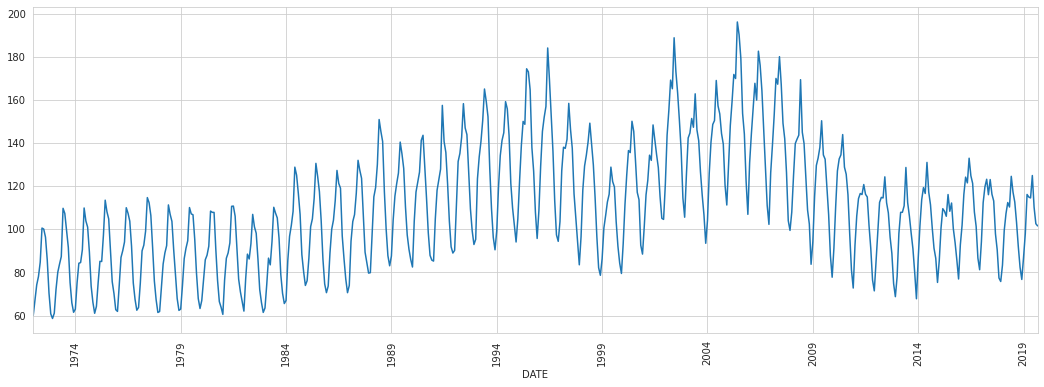

In [7]:
df['Production'].plot(figsize=(18,6))
plt.xticks(rotation=90);

# Preprocessing of Data

## Train Test Split

In [8]:
len(df)

573

In [9]:
test_ind = round(len(df)*0.15)
test_ind

86

In [10]:
train = df.iloc[:-test_ind]
test = df.iloc[-test_ind:]

In [11]:
train.shape, test.shape

((487, 1), (86, 1))

## Scaling

In [12]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler

In [13]:
scaler = MinMaxScaler()

In [14]:
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## Time Series Generator

In [15]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [16]:
length = 12
batch_size = 1
generator = TimeseriesGenerator(train_scaled, train_scaled, length = length, batch_size = batch_size)

In [17]:
len(generator)

475

In [18]:
generator[0]

(array([[[0.00947104],
         [0.06108982],
         [0.11326273],
         [0.14145625],
         [0.18982663],
         [0.30495972],
         [0.30154406],
         [0.27416065],
         [0.19736841],
         [0.08532665],
         [0.01561588],
         [0.        ]]]), array([[0.01774221]]))

In [19]:
X, y = generator[0]

In [20]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.00947104 0.06108982 0.11326273 0.14145625 0.18982663 0.30495972
 0.30154406 0.27416065 0.19736841 0.08532665 0.01561588 0.        ]
Predict this y: 
 [[0.01774221]]


# Modelling & Model Performance

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [22]:
train_scaled.shape

(487, 1)

In [23]:
n_features = train_scaled.shape[1]

## with "tanh" activation function

In [24]:
model = Sequential()
model.add(LSTM(100, activation = 'tanh', return_sequences=True, input_shape = (length, n_features)))
model.add(LSTM(50, activation = 'tanh'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


## EarlyStopping and Validation Generator




In [26]:
from tensorflow.keras.callbacks import EarlyStopping

In [27]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5,restore_best_weights = True)

In [28]:
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = batch_size)

In [29]:
len(validation_generator)

74

In [30]:
model.fit(x = generator,
          epochs = 120,
          validation_data = validation_generator,
          callbacks = [early_stop])

Epoch 1/120
475/475 [==============================] - 13s 18ms/step - loss: 0.0207 - val_loss: 0.0046
Epoch 2/120
475/475 [==============================] - 6s 13ms/step - loss: 0.0060 - val_loss: 0.0033
Epoch 3/120
475/475 [==============================] - 7s 15ms/step - loss: 0.0048 - val_loss: 0.0028
Epoch 4/120
475/475 [==============================] - 7s 14ms/step - loss: 0.0042 - val_loss: 0.0023
Epoch 5/120
475/475 [==============================] - 8s 17ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 6/120
475/475 [==============================] - 9s 19ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 7/120
475/475 [==============================] - 6s 13ms/step - loss: 0.0038 - val_loss: 0.0032
Epoch 8/120
475/475 [==============================] - 6s 13ms/step - loss: 0.0035 - val_loss: 0.0021
Epoch 9/120
475/475 [==============================] - 11s 23ms/step - loss: 0.0032 - val_loss: 0.0022
Epoch 10/120
475/475 [==============================] - 6s 12ms/step - loss: 0.0

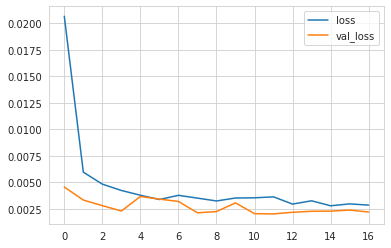

In [31]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

### Evaluation on Test Data

In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [33]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\nmae:", mae, "\nmse:",mse, "\nrmse:",rmse)

In [34]:
predictions_scaled = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)
    
    # store prediction
    predictions_scaled.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis=1)

In [35]:
predictions_scaled

[array([0.35743266], dtype=float32),
 array([0.26979092], dtype=float32),
 array([0.1886042], dtype=float32),
 array([0.15206826], dtype=float32),
 array([0.1739668], dtype=float32),
 array([0.22931778], dtype=float32),
 array([0.28610358], dtype=float32),
 array([0.3331446], dtype=float32),
 array([0.37038594], dtype=float32),
 array([0.39785457], dtype=float32),
 array([0.4086368], dtype=float32),
 array([0.38735807], dtype=float32)]

In [36]:
eval_metrics(test_scaled[:length], predictions_scaled)

r2_score: 0.8301629694030103 
mae: 0.034879837089511194 
mse: 0.0026003671573732717 
rmse: 0.05099379528308588


### Inverse Transformation and Comparing

In [37]:
predictions = scaler.inverse_transform(predictions_scaled)

In [38]:
compare = test[:12]

In [39]:
compare['Predictions'] = predictions

In [40]:
compare

,Production,Predictions
DATE,,
2012-08-01,107.643,107.812
2012-09-01,96.370,95.760
2012-10-01,88.886,84.595
2012-11-01,74.838,79.571
2012-12-01,68.769,82.583
2013-01-01,78.118,90.194
2013-02-01,98.034,98.003
2013-03-01,107.884,104.472
2013-04-01,107.910,109.593


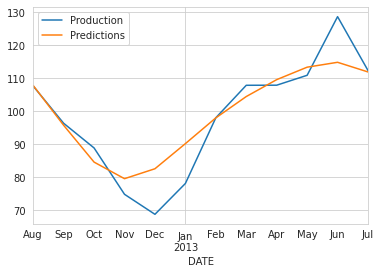

In [41]:
compare.plot()

In [42]:
eval_metrics(compare.Production, compare.Predictions)

r2_score: 0.8301629694030102 
mae: 4.796462429543336 
mse: 49.17313197496446 
rmse: 7.012355665178747


## with "relu" activation function

In [43]:
modelrelu = Sequential()
modelrelu.add(LSTM(100, activation = 'relu', return_sequences=True, input_shape = (length, n_features)))
modelrelu.add(LSTM(50, activation = 'relu'))
modelrelu.add(Dense(1))
modelrelu.compile(optimizer = 'adam', loss = 'mse')

In [44]:
modelrelu.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 12, 100)           40800     
                                                                 
 lstm_3 (LSTM)               (None, 50)                30200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


## EarlyStopping and Validation Generator


In [45]:
from tensorflow.keras.callbacks import EarlyStopping


In [46]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5,restore_best_weights = True)

In [47]:
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = batch_size)

In [48]:
len(validation_generator)

74

In [49]:
modelrelu.fit(x = generator,
          epochs = 120,
          validation_data = validation_generator,
          callbacks = [early_stop])

Epoch 1/120
475/475 [==============================] - 10s 14ms/step - loss: 0.0275 - val_loss: 0.0120
Epoch 2/120
475/475 [==============================] - 7s 14ms/step - loss: 0.0089 - val_loss: 0.0043
Epoch 3/120
475/475 [==============================] - 6s 13ms/step - loss: 0.0068 - val_loss: 0.0049
Epoch 4/120
475/475 [==============================] - 6s 13ms/step - loss: 0.0073 - val_loss: 0.0027
Epoch 5/120
475/475 [==============================] - 7s 14ms/step - loss: 0.0052 - val_loss: 0.0025
Epoch 6/120
475/475 [==============================] - 6s 12ms/step - loss: 0.0042 - val_loss: 0.0027
Epoch 7/120
475/475 [==============================] - 7s 15ms/step - loss: 0.0042 - val_loss: 0.0031
Epoch 8/120
475/475 [==============================] - 6s 13ms/step - loss: 0.0037 - val_loss: 0.0020
Epoch 9/120
475/475 [==============================] - 6s 12ms/step - loss: 0.0039 - val_loss: 0.0028
Epoch 10/120
475/475 [==============================] - 7s 14ms/step - loss: 0.00

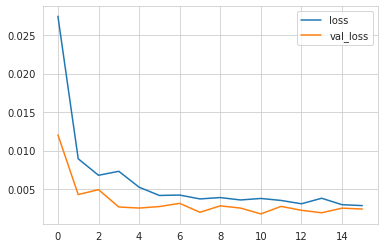

In [50]:
loss_df = pd.DataFrame(modelrelu.history.history)
loss_df.plot()

### Evaluation on Test Data

In [51]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [52]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\nmae:", mae, "\nmse:",mse, "\nrmse:",rmse)

In [53]:
predictions_scaled = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead
    current_pred = modelrelu.predict(current_batch)
    
    # store prediction
    predictions_scaled.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis=1)

In [54]:
predictions_scaled

[array([0.37899595], dtype=float32),
 array([0.2928111], dtype=float32),
 array([0.2067897], dtype=float32),
 array([0.13043982], dtype=float32),
 array([0.12174813], dtype=float32),
 array([0.18088502], dtype=float32),
 array([0.26051727], dtype=float32),
 array([0.3314404], dtype=float32),
 array([0.38482338], dtype=float32),
 array([0.4291703], dtype=float32),
 array([0.4581425], dtype=float32),
 array([0.44770643], dtype=float32)]

In [55]:
eval_metrics(test_scaled[:length], predictions_scaled)

r2_score: 0.9158893909258604 
mae: 0.032604607046188165 
mse: 0.0012878137627244375 
rmse: 0.03588612214665214


### Inverse Transformation and Comparing

In [56]:
predictions = scaler.inverse_transform(predictions_scaled)

In [57]:
compare = test[:12]

In [58]:
compare['Predictions'] = predictions

In [59]:
compare

,Production,Predictions
DATE,,
2012-08-01,107.643,110.777
2012-09-01,96.370,98.925
2012-10-01,88.886,87.096
2012-11-01,74.838,76.597
2012-12-01,68.769,75.402
2013-01-01,78.118,83.534
2013-02-01,98.034,94.485
2013-03-01,107.884,104.237
2013-04-01,107.910,111.578


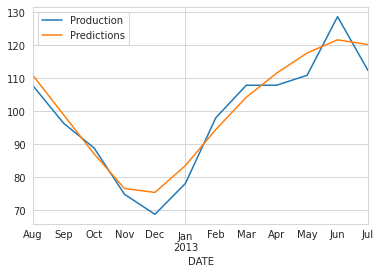

In [60]:
compare.plot()

In [61]:
eval_metrics(compare.Production, compare.Predictions)

r2_score: 0.9158893909258604 
mae: 4.4835866728888165 
mse: 24.35265186843543 
rmse: 4.93484061226251


# Retrain and Forecasting

Select activation function providing a better score, create your final model with full data, forecast for the next 12 months, and plot this forecast.

In [62]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [63]:
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length = length, batch_size = batch_size)

In [64]:
len(df)

573

In [65]:
len(generator)

561

In [67]:
model = Sequential()
model.add(LSTM(100, activation = 'relu', return_sequences=True, input_shape = (length, n_features)))
model.add(LSTM(50, activation = 'relu'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

model.fit(x = generator, epochs=20)

Epoch 1/20
561/561 [==============================] - 10s 11ms/step - loss: 0.0246
Epoch 2/20
561/561 [==============================] - 7s 12ms/step - loss: 0.0097
Epoch 3/20
561/561 [==============================] - 7s 13ms/step - loss: 0.0074
Epoch 4/20
561/561 [==============================] - 6s 11ms/step - loss: 0.0071
Epoch 5/20
561/561 [==============================] - 6s 11ms/step - loss: 0.0070
Epoch 6/20
561/561 [==============================] - 7s 12ms/step - loss: 0.0061
Epoch 7/20
561/561 [==============================] - 7s 13ms/step - loss: 0.0062
Epoch 8/20
561/561 [==============================] - 8s 13ms/step - loss: 0.0061
Epoch 9/20
561/561 [==============================] - 8s 14ms/step - loss: 0.0062
Epoch 10/20
561/561 [==============================] - 8s 14ms/step - loss: 0.0050
Epoch 11/20
561/561 [==============================] - 8s 14ms/step - loss: 0.0051
Epoch 12/20
561/561 [==============================] - 7s 13ms/step - loss: 0.0050
Epoch 13/20


In [68]:
scaled_full_data.shape

(573, 1)

In [69]:
scaled_full_data[-length:].shape

(12, 1)

In [70]:
forecast = []

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)
    
    # store prediction
    forecast.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis = 1)

In [71]:
forecast = scaler.inverse_transform(forecast)
forecast

array([[ 86.18798741],
       [ 78.31528275],
       [ 75.83440271],
       [ 84.68678806],
       [ 98.17640666],
       [108.45966568],
       [113.0598714 ],
       [117.88513571],
       [117.66192132],
       [110.49648367],
       [103.04504259],
       [ 93.50629737]])

In [72]:
df.tail()

,Production
DATE,
2019-05-01,114.561
2019-06-01,124.960
2019-07-01,110.263
2019-08-01,102.609
2019-09-01,101.587


In [73]:
forecast_index = pd.date_range(start = '2019-10-01', periods = length, freq = 'MS')
forecast_index

DatetimeIndex(['2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
               '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01'],
              dtype='datetime64[ns]', freq='MS')

In [74]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['Forecast'])
forecast_df

,Forecast
2019-10-01,86.188
2019-11-01,78.315
2019-12-01,75.834
2020-01-01,84.687
2020-02-01,98.176
2020-03-01,108.460
2020-04-01,113.060
2020-05-01,117.885
2020-06-01,117.662
2020-07-01,110.496


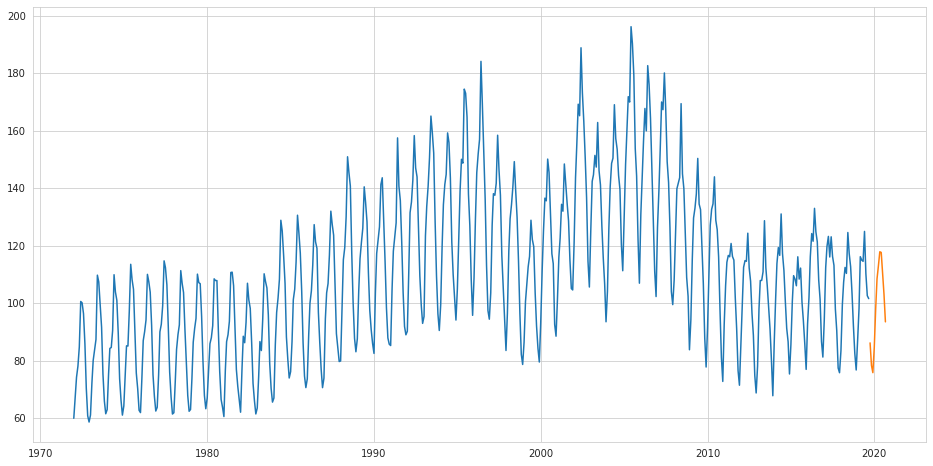

In [75]:
plt.figure(figsize = (16, 8))
plt.plot(df.index, df['Production'])
plt.plot(forecast_df.index, forecast_df['Forecast'])

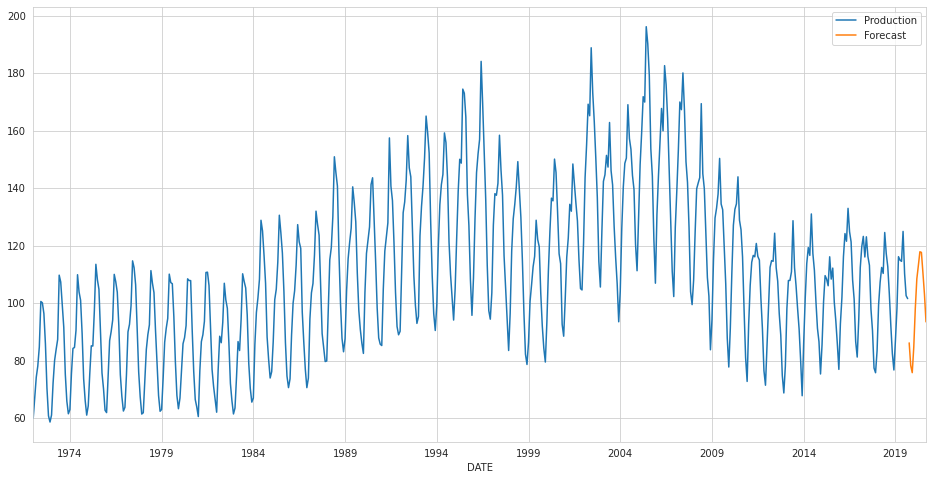

In [76]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8));

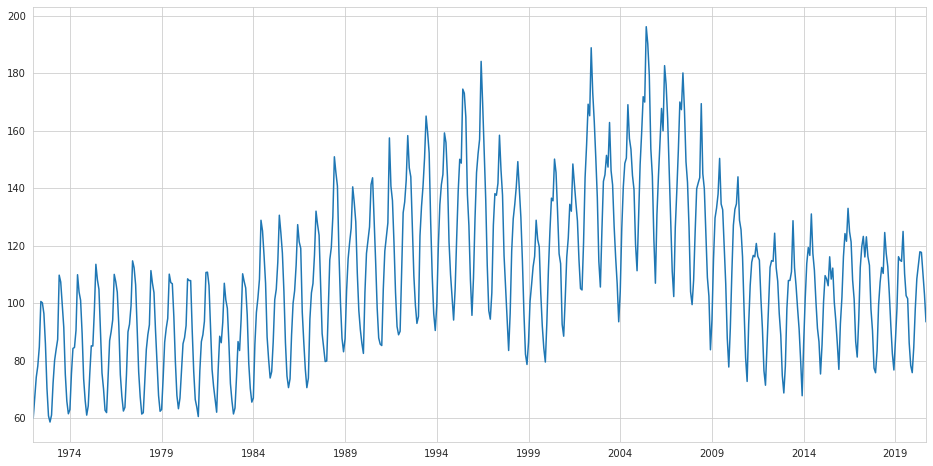

In [78]:
dataset_total = pd.concat((df['Production'], forecast_df['Forecast']), axis=0)
dataset_total.plot(figsize = (16, 8))

___

<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="CLRSWY"></p>

___